In [128]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import zipfile

In [129]:
zip_path = 'data/data_median_redfin.csv.zip'

with zipfile.ZipFile(zip_path, 'r') as z:
    with z.open("data_median_redfin.csv") as f:  # Change "yourfile.csv" to the actual filename
        df = pd.read_csv(f)

df = df.iloc[:, 1:]

/var/folders/r6/j2xslqfj0lg0bxy1nj8b6fzm0000gn/T/ipykernel_19754/2567003737.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


In [130]:
columns = ['PostalCode', 'PoolPrivateYN', 'ViewYN', 'DaysOnMarket', 'BedroomsTotal',
            'BathroomsTotalInteger', 'YearBuilt', 'LivingArea',  'AttachedGarageYN', 
            'ElementarySchool', 'ElementarySchoolDistrict', 'MiddleOrJuniorSchool', 'MiddleOrJuniorSchoolDistrict', 
            'HighSchool', 'HighSchoolDistrict', 'ClosePrice', 'January', 'median_sale_price']
df = df[columns]

In [131]:
df.isna().sum()

PostalCode                          0
PoolPrivateYN                   10858
ViewYN                           8226
DaysOnMarket                        0
BedroomsTotal                       0
BathroomsTotalInteger              17
YearBuilt                          72
LivingArea                         49
AttachedGarageYN                10136
ElementarySchool                77683
ElementarySchoolDistrict        91072
MiddleOrJuniorSchool            77599
MiddleOrJuniorSchoolDistrict    91072
HighSchool                      73650
HighSchoolDistrict              22809
ClosePrice                          2
January                         41187
median_sale_price                 816
dtype: int64

In [132]:
def fill_missing(df):
    output = df.copy()
    def mean_impute_numerical(col):
        return col.fillna(col.mean())
    
    def median_impute(col):
        median = col.median()
        return col.fillna(median)
    
    # impute these values based on the mean value of postal code
    for col in ['BathroomsTotalInteger', 'YearBuilt', 'LivingArea']:
        new_col = output.groupby('PostalCode')[col].transform(mean_impute_numerical)
        output[col] = new_col

    # if percentage of True is above 0.5, fill in missing values with True, else False
    def mean_impute_TF(col):
        if col.mean() > 0.5:
            return col.fillna(True)
        return col.fillna(False)
    
    # use above function to impute
    for col in ['PoolPrivateYN', 'ViewYN', 'AttachedGarageYN']:
        new_col = output.groupby('PostalCode')[col].transform(mean_impute_TF)
        output[col] = new_col

    # fill in other missing values for homes that are in their only zip code
    for col in ['BathroomsTotalInteger', 'YearBuilt', 'LivingArea']:
        output[col] = mean_impute_numerical(output[col])
    for col in ['PoolPrivateYN', 'ViewYN', 'AttachedGarageYN']:
        output[col] = mean_impute_TF(output[col])

    # fill in missing values for monthly zestimates with median
    for col in ['January', 'median_sale_price']:
        output[col] = median_impute(output[col])
        
    output = output.dropna(subset=['ClosePrice']) # drop where ClosePrice is missing
    
    return output

In [133]:
def engineer_schools(df):
    copy = df.copy()
    # no need for elementary school district or middle school district because all values in those are missing
    cols = ['ElementarySchool', 'MiddleOrJuniorSchool', 'HighSchool', 'HighSchoolDistrict']
    sum = pd.Series(np.zeros(df.shape[0]), index=df.index)
    for col in cols:
        sum += (1- copy[col].isna())
    copy['total_schools'] = sum
    copy = copy.drop(columns=['ElementarySchool', 'ElementarySchoolDistrict','MiddleOrJuniorSchool', 
                              'MiddleOrJuniorSchoolDistrict', 'HighSchool', 'HighSchoolDistrict'])
    return copy

In [134]:
def binary_encode(df):
    output = df.copy()
    columns = ['PoolPrivateYN', 'ViewYN', 'AttachedGarageYN']
    for col in columns:
        output[col] = output[col].astype(int)
    return output

def engineer_postal_code(df):
    copy = df.copy()
    def cut_off(value):
        if len(value) > 5:
            return int(value[:4]) # if the postal code is in the form XXXXX-XXXX, cut off the second part
        return int(value)
    copy['PostalCode'] = copy['PostalCode'].transform(cut_off)
    return copy
    

In [135]:
def preprocess(df):
    output = df.copy()
    output = fill_missing(output)
    output = engineer_schools(output)
    output = binary_encode(output)
    output = engineer_postal_code(output)
    return output

In [136]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

In [137]:
features = [
    "PoolPrivateYN", "ViewYN", "DaysOnMarket", "BedroomsTotal",
    "BathroomsTotalInteger", "YearBuilt", "LivingArea",
    "AttachedGarageYN", "total_schools", 'PostalCode','median_sale_price', 'January'
]


target = "ClosePrice"  # Replace with actual target column name
cleaned_df = preprocess(df)
display(cleaned_df)

X = cleaned_df[features]
y = cleaned_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/r6/j2xslqfj0lg0bxy1nj8b6fzm0000gn/T/ipykernel_19754/1749265984.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return col.fillna(False)
/var/folders/r6/j2xslqfj0lg0bxy1nj8b6fzm0000gn/T/ipykernel_19754/1749265984.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return col.fillna(True)
/var/folders/r6/j2xslqfj0lg0bxy1nj8b6fzm0000gn/T/ipykernel_19754/1749265984.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

,PostalCode,PoolPrivateYN,ViewYN,DaysOnMarket,BedroomsTotal,BathroomsTotalInteger,YearBuilt,LivingArea,AttachedGarageYN,ClosePrice,January,median_sale_price,total_schools
0,94025,0,0,0,3.0,2.0,1948.0,1831.0,0,3000000.0,1.600010e+06,1893750.0,1.0
1,90254,1,1,0,5.0,5.0,2024.0,5000.0,1,7750000.0,2.888148e+05,1665000.0,1.0
2,93906,0,0,0,2.0,1.0,1950.0,863.0,1,575000.0,2.888148e+05,385000.0,1.0
3,90046,0,0,0,3.0,1.0,1923.0,1338.0,1,1810000.0,2.888148e+05,1268500.0,0.0
4,92057,0,0,0,4.0,4.0,2009.0,3203.0,1,1135000.0,2.888148e+05,409250.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91067,92651,0,1,248,4.0,3.0,1977.0,2822.0,1,4000000.0,3.873717e+05,1769000.0,1.0
91068,92352,0,1,546,6.0,7.0,1985.0,5846.0,1,4600000.0,5.933673e+05,399850.0,1.0
91069,92365,0,1,480,3.0,2.0,1984.0,1909.0,1,170000.0,2.888148e+05,105250.0,1.0
91070,95121,0,0,23,3.0,2.0,1965.0,1720.0,1,1071000.0,2.888148e+05,675000.0,1.0


In [138]:
X.isna().sum()

PoolPrivateYN            0
ViewYN                   0
DaysOnMarket             0
BedroomsTotal            0
BathroomsTotalInteger    0
YearBuilt                0
LivingArea               0
AttachedGarageYN         0
total_schools            0
PostalCode               0
median_sale_price        0
January                  0
dtype: int64

In [139]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [140]:
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))  # Residual sum of squares
    mean_y = tf.reduce_mean(y_true)
    ss_tot = tf.reduce_sum(tf.square(y_true - mean_y))  # Total sum of squares
    return 1 - (ss_res / (ss_tot + tf.keras.backend.epsilon()))  # Avoid division by zero

Epoch 1/60


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2277/2277 ━━━━━━━━━━━━━━━━━━━━ 2s 734us/step - loss: 813955.4375 - mae: 813955.4375 - r2_score: -0.5884 - val_loss: 304759.9375 - val_mae: 304759.9375 - val_r2_score: 0.7000
Epoch 2/60
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - loss: 353078.6875 - mae: 353078.6875 - r2_score: 0.6388 - val_loss: 260758.6094 - val_mae: 260758.6094 - val_r2_score: 0.7528
Epoch 3/60
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 2s 662us/step - loss: 329608.8125 - mae: 329608.8125 - r2_score: 0.6764 - val_loss: 250258.4844 - val_mae: 250258.4844 - val_r2_score: 0.7641
Epoch 4/60
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - loss: 325870.0312 - mae: 325870.0312 - r2_score: 0.7006 - val_loss: 250098.2031 - val_mae: 250098.2031 - val_r2_score: 0.7406
Epoch 5/60
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 2s 663us/step - loss: 302552.1562 - mae: 302552.1562 - r2_score: 0.7136 - val_loss: 248745.1406 - val_mae: 248745.1406 - val_r2_score: 0.7401
Epoch 6/60
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 2s 658us/step - loss: 307458.3125 - mae: 307458.

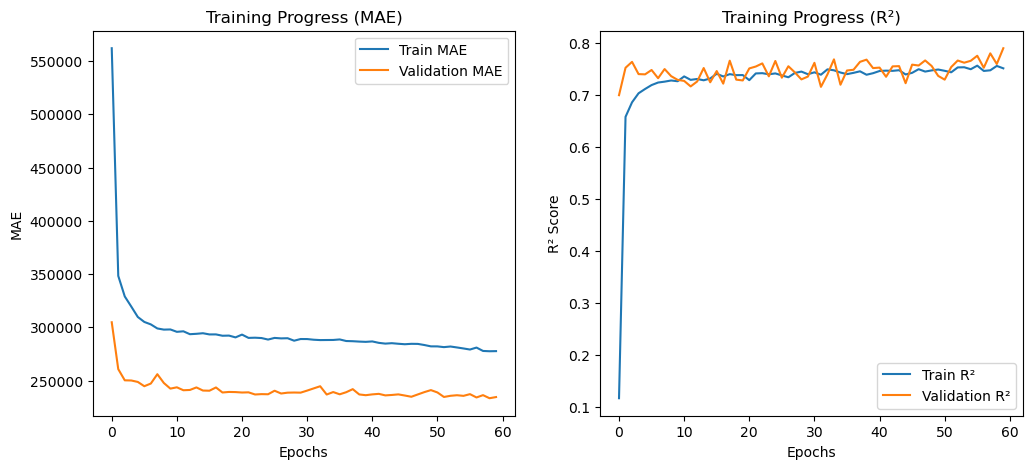

In [141]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # No activation for regression
])

# Compile model with R² and MAE
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae', r2_score])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=32, verbose=1)

# Evaluate
loss, mae, r2 = model.evaluate(X_test, y_test)
print(f"Final MAE: {mae:.2f}")
print(f"Final R²: {r2:.2f}")

# Plot MAE & R²
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training Progress (MAE)')

plt.subplot(1, 2, 2)
plt.plot(history.history['r2_score'], label='Train R²')
plt.plot(history.history['val_r2_score'], label='Validation R²')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.title('Training Progress (R²)')

plt.show()
